## Sparse flight data

A key question for the generation of sparse state networks is _how_ sparse. If we lump all state nodes with each physical node, we lose all higher-order information and may underfit. On the other hand, keeping all second-order state nodes may overfit.

In this tutorial we will generate second-order state networks from path data and from there generate multiple sparse networks with different number of (lumped) state nodes and evaluate the result with Infomap

### Generate training and validation sets
To get a bigger network, we can merge the flight path data from the four quarters (`"data/air2015_{q}_paths.net" for q in [1,2,3,4]`). But to evaluate the goodness of fit, we can split each individual path randomly in either a _training_ or a _validation_ set. `StateNetwork` can generate that split to preserve same stateId for same physical n-grams between the networks.

In [1]:
import numpy as np

In [2]:
def combinePaths(inputFilenames, outputFilename):
    """Merge path data from inputFilenames and write to a single path data file"""
    # Read path data
    paths = []
    for filename in inputFilenames:
        print("Parsing paths from '{}'...".format(filename))
        with open(filename, mode='r') as infile:
            isPath = False
            for row in infile:
                if not isPath and row[:6] == "*paths":
                    isPath = True
                    continue
                if not isPath:
                    continue
                paths.append(row)
    # Write path data
    print("-> Writing {} paths to {}...".format(len(paths), outputFilename))
    with open(outputFilename, mode='w') as outfile:
        outfile.write("*paths\n")
        for p in paths:
            outfile.write(p)

inputFilenames = ["data/air2015_{}_paths.net".format(quarter) for quarter in [1,2,3,4]]
combinePaths(inputFilenames, "output/air2015_paths.net")

Parsing paths from 'data/air2015_1_paths.net'...
Parsing paths from 'data/air2015_2_paths.net'...
Parsing paths from 'data/air2015_3_paths.net'...
Parsing paths from 'data/air2015_4_paths.net'...
-> Writing 67025 paths to output/air2015_paths.net...


#### Generate state networks from paths

In [3]:
from state_lumping_network import StateNetwork

pathNetwork = StateNetwork()
pathNetwork.generateStateNetworkFromPaths("output/air2015_paths.net",
                                          "output/states_training_order_2.net",
                                          outputValidationFilename="output/states_validation_order_2.net",
                                          markovOrder=2, splitWeight=True, validationProb=0.2)

Read path data from file 'output/air2015_paths.net'...
Generated training state network: StateNetwork (360 physical nodes, 5517 state nodes and 25667 links)
Writing state network to file 'output/states_training_order_2.net'...
Generated validation state network: StateNetwork (360 physical nodes, 5516 state nodes and 25622 links)
Writing state network to file 'output/states_validation_order_2.net'...
Done!


### Generate _sparse_ state networks

Here we will generate multiple lumped state networks with different amount of state nodes. A simple way is to parameterise this with a cluster rate $r$ going from 0.1 to 1, where `n_clusters = max(1, int(r * numStateNodes)`. For convenience, you can just send in the argument `clusterRate` to `clusterStateNodes` to achieve this, instead of the cluster function in the previous tutorial.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

print("Lumping training network with different cluster rates and lump validation network similarly")
trainingNet = StateNetwork()
trainingNet.readFromFile("output/states_training_order_2.net")
validationNet = StateNetwork()
validationNet.readFromFile("output/states_validation_order_2.net")

h0 = trainingNet.calcEntropyRate()
print("\nOriginal average entropy rate:", h0)
print("Original number of state nodes:", trainingNet.numStateNodes())

clusterRates = np.linspace(0.1, 1, 10)
# clusterRates = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.98, 0.99, 0.999, 1.0]
trainNumStates = []
trainEntropyRate = []
valNumStates = []
valEntropyRate = []

for i, clusterRate in enumerate(clusterRates):
    trainingNet.clusterStateNodes(clusterRate=clusterRate)
    s = trainingNet.numLumpedStateNodes()
    h = trainingNet.calcLumpedEntropyRate()
    trainNumStates.append(s)
    trainEntropyRate.append(h)
    trainingNet.writeLumpedStateNetwork("output/states_training_lumped_{}.net".format(i))
    validationNet.clusterStateNodesFromNetwork(trainingNet)
    validationNet.writeLumpedStateNetwork("output/states_validation_lumped_{}.net".format(i))
    s = trainingNet.numLumpedStateNodes()
    h = trainingNet.calcLumpedEntropyRate()
    valNumStates.append(s)
    valEntropyRate.append(h)

Lumping training network with different cluster rates and lump validation network similarly
Read state network from file 'output/states_training_order_2.net'...
 -> StateNetwork (360 physical nodes, 5517 state nodes and 25667 links)
Read state network from file 'output/states_validation_order_2.net'...
 -> StateNetwork (360 physical nodes, 5516 state nodes and 25622 links)

Original average entropy rate: 4.039250655423245
Original number of state nodes: 5517
Cluster state nodes...
Generate lumped state network from clustering...
 -> 819 state nodes and 8916 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_0.net'...
Cluster state nodes from clustering in network StateNetwork (360 physical nodes, 5517 state nodes and 25667 links)...
Generate lumped state network from clustering...
 -> 818 state nodes and 8910 links in lumped network.
Writing lumped state network to file 'output/states_validation_lumped_0.net'...
Cluster state nodes...
Generate 

#### How much information do we lose as we reduce the number of state nodes?

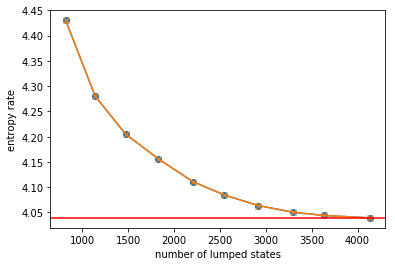

In [5]:
plt.plot(trainNumStates, trainEntropyRate, marker='o')
plt.plot(valNumStates, valEntropyRate, marker='x')
plt.xlabel("number of lumped states")
plt.ylabel("entropy rate")
plt.axhline(y=h0, color='r', linestyle='-')
# plt.axvline(x=sparseNet.numStateNodes(), color='r')
plt.show()

Note that the original number of state nodes can be much larger than the maximum in the lumped state networks due to dangling nodes which are lumped implicitly.

### Validate with Infomap
The goal here is to calculate the codelength for the validation network, given the different partitions found on the lumped training networks.

In [6]:
import infomap
trainingCodelengths = []
validationCodelengths = []

def calcCodelength(inputFilename, cluInputFile, flags="--directed --two-level"):
    im = infomap.Infomap("{} --no-infomap --input {} --cluster-data {}".format(flags, inputFilename, cluInputFile))
    im.run()
    return im.codelength()

def partition(inputFilename, cluOutputFile=None, flags="--directed --two-level"):
    im = infomap.Infomap(flags)
    im.network().readInputData(inputFilename)
    im.run()
    if cluOutputFile:
        # Use second argument True to write the state-level clustering
        im.writeClu(cluOutputFile, True) # Second parameter shows States
    return im.codelength()


for i, clusterRate in enumerate(clusterRates):
    trainingCodelength = partition("output/states_training_lumped_{}.net".format(i),
             "output/states_training_lumped_{}.clu".format(i))
    validationCodelength = calcCodelength("output/states_validation_lumped_{}.net".format(i),
             "output/states_training_lumped_{}.clu".format(i))
    trainingCodelengths.append(trainingCodelength)
    validationCodelengths.append(validationCodelength)
    print("{}: training codelength: {} ({} nodes), validation codelength: {} ({} nodes)".format(i, trainingCodelength, trainNumStates[i], validationCodelength, valNumStates[i]))


0: training codelength: 7.60007830233651 (819 nodes), validation codelength: 7.601660621880729 (819 nodes)
1: training codelength: 7.721968725630215 (1140 nodes), validation codelength: 7.722841750117088 (1140 nodes)
2: training codelength: 7.67089939136898 (1472 nodes), validation codelength: 7.679476052496824 (1472 nodes)
3: training codelength: 7.6244864051698 (1829 nodes), validation codelength: 7.632618458782786 (1829 nodes)
4: training codelength: 7.522692497178666 (2207 nodes), validation codelength: 7.532016357467938 (2207 nodes)
5: training codelength: 7.507194482791788 (2548 nodes), validation codelength: 7.521862859402333 (2548 nodes)
6: training codelength: 7.458040140186282 (2916 nodes), validation codelength: 7.509058954093378 (2916 nodes)
7: training codelength: 7.469911037553323 (3296 nodes), validation codelength: 7.526147887354373 (3296 nodes)
8: training codelength: 7.466626467188993 (3638 nodes), validation codelength: 7.5951295721288234 (3638 nodes)
9: training cod

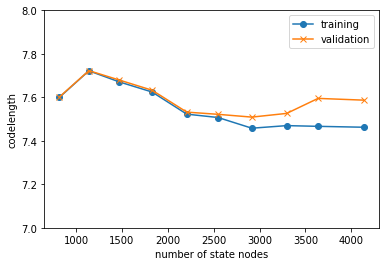

In [7]:
plt.plot(trainNumStates, trainingCodelengths, marker='o')
plt.plot(valNumStates, validationCodelengths, marker='x')
plt.legend(["training", "validation"])
plt.xlabel("number of state nodes")
plt.ylabel("codelength")
plt.ylim(ymin=7, ymax=8)
plt.show()